# K NEAREST NEIGHBORS ANALYSIS

In this jupyter notebook we will do some regression analysis on a sequence having multiple and different local trends. We will first construct some functions to generate a sequence having multiple local trends. Then we will investigate the performance of model fits of linear models having different complexities. We will cap off the jupyter notebook by analyzing how KNN regressor outperforms linear models in this situation, where the data has local trends across its features.

**Append the directory of m_learn package to the system path**

In [1]:
from config import *
append_path('../../')

**Import necessary packages and modules** 

In [2]:
import numpy as np
np.random.seed(0)
import pandas as pd
import math
from m_learn.neighbors import knn_regressor
from m_learn.utility.data_preprocessing import get_xy_data, polynomial_dataFrame
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Generate sequence having different local trends

### 1.1 Functions to create sequence having multiple local trends

**Functions to compute cube root and cube of a number**

In [3]:
def cube_root_function(n):
    '''
    Cube root function
    '''    
    return n**(1/3)

def cubic_function(n):    
    '''
    Cubic function
    '''    
    return n**3

**Function to generate a sequence according to mathematical function passed as an argument**

In [4]:
def sequence_generator(func, values):
    '''
    A function which act as a sequence generator
    Arguments:
    func - mathematical function/operator for the sequence 
    values - a list of input values of the sequence
    '''    
    # iterate through each given value
    for i in values:        
        # yield the resultant value returned 
        # by the given mathematical operator/function
        yield func(i)

**Function to generate a sequence having multiple local trends**

In [5]:
def multiple_trend_sequence_generator(number, start, first_range):
    
    '''
    A function for generating sequence having multiple local trends
    '''    
    # divide the total range into three subranges,
    # each subrange has a different trend
    subrange = number//3

    # generate the x values of the sequence
    x = list(range(start,number+1))

    ####first subrange operations####
    # create x range of for first trend
    range_1 = np.linspace(first_range[0],first_range[1],subrange)
    # generate the y values of sequence for the first subrange
    sequence_1 = sequence_generator(cube_root_function, range_1)
    # convert the generator into a list
    sequence_1 = list(sequence_1)

    ####second subrange operations####
    # extract the last value of first subrange, 
    # this will be the first value of second subrange
    value = sequence_1[-1]
    # generate the y values of sequence for the second subrange
    sequence_2 = [value for n in range(subrange)]

    ####third subrange operations####
    # extract the last value of second subrange, 
    # this will be the first value of third subrange
    value = sequence_2[-1]**(1/3) ##cube root operations so that a contiguous range of data is formed
    range_3 = np.linspace(value, value+1, subrange)
    # generate the y values of sequence for the third subrange
    sequence_3 = sequence_generator(cubic_function, range_3)
    # convert the generator into a list
    sequence_3 = list(sequence_3)

    # concatenate the three sequences into a single list
    y = sequence_1
    y.extend(sequence_2)
    y.extend(sequence_3)
    
    # return x y values of the sequence having multiple local trends
    return x, y

### 1.2 Generate and visualize the sequence having multiple local trends

**Generate a sequence having multiple local trends using the above function**

In [6]:
x, y = multiple_trend_sequence_generator(number = 6000, start = 1, first_range=(0, 100000))

**Store the xy data in a pandas dataframe**

In [7]:
data = pd.DataFrame({"house_size":x,"house_price":y})

**Plot of the sequence**

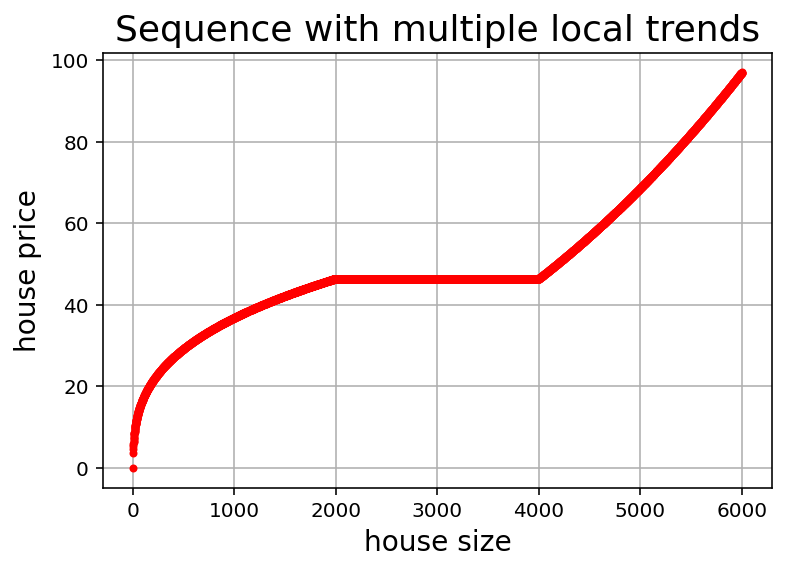

In [8]:
plt.plot(data.house_size, data.house_price, '.', linewidth =2, color = 'r')
plt.title("Sequence with multiple local trends", fontsize = 18)
plt.xlabel("house size", fontsize = 14)
plt.ylabel("house price", fontsize = 14)
plt.grid()
plt.show()

## 2. Plots of model fits of linear regression models having different complexities

### 2.1 A function to plot the model fits of linear regression models having different complexities on the sequence having multiple local trends

In [9]:
def polynomial_regression_plot(degrees, regression_model, train_data,test_data,\
                               feature, output, subplot_dimension, **kwargs): 

    '''
    A function which plots fits of regression models having different complexities
    Arguments:
    degrees - list of degrees of model complexities we are going to test in our investigation
    regression_model - a sklearn regression model
    train_data - a pandas dataframe containing training set
    test_data - a pandas dataframe containing test set
    feature - list of features of the model
    output - name of the output of the model (string)
    subplot_dimension - dimension of the subplot
    **kwargs - keywords arguments passed to the regression model
    Returns:
    r2_scores - list to store the r-squared scores on test data of all the models
    '''    

    # a list to store the r squared score of all the models
    r2_scores = []

    # extract the output column of training data
    train_output = train_data[output]
    # extract the output column of test data
    test_output = test_data[output]

    # iterate through each degree of complexity
    for degree in degrees:
        # create polynomial data of given degree complexity of the training set
        polynomial_train = polynomial_dataFrame(train_data[feature], degree)
        # create and fit regression model using the polynomial data of training set
        model = regression_model(**kwargs)
        model.fit(polynomial_train, train_output)
        # extract the names of the feature columns from the polynomial dataframe
        feature_columns = polynomial_train.columns.values.tolist()
        # add the output column to the polynomial data
        polynomial_train[output] = train_output
        # sort the dataframe by power 1 so that points in the plot join sequentially
        polynomial_train = polynomial_train.sort_values(['power1', output])
        
        # compute predictions of training set
        predictions_train = model.predict(polynomial_train[feature_columns])
        # line plots of training data and model fit on training data
        plt.subplot(subplot_dimension[0], subplot_dimension[1], degree)
        plt.plot(polynomial_train['power1'], polynomial_train[output], '-', linewidth = 6, color = 'r', label = "train sequence")
        plt.plot(polynomial_train['power1'], predictions_train, '-', linewidth = 3, color = 'b', label = 'model fit')
        plt.xlabel("house size", fontsize= 14)
        plt.ylabel("house price", fontsize= 14)
        plt.legend()  
        plt.grid()
        plt.title("degree of polynomial: " + str(degree))
        
        # create polynomial data of given degree complexity of the test set
        polynomial_test = polynomial_dataFrame(test_data[feature], degree)
        # compute predictions of test set
        predictions_test = model.predict(polynomial_test)
        # compute the r-squared score using test set
        score = r2_score(test_output, predictions_test)
        # append the r-quared score to the designated list
        r2_scores.append(score)
     
    # adjust height and width space of the subplots
    plt.subplots_adjust(wspace = 0.45, hspace = 0.40)
    # add the grand title to the whole figure
    plt.suptitle("Fits of regression models having different complexities", fontsize = 16)
    # show the plot         
    plt.show() 

    # return the r-squared scores of models having different complexities
    return r2_scores

### 2.2 Plots of regression model fits

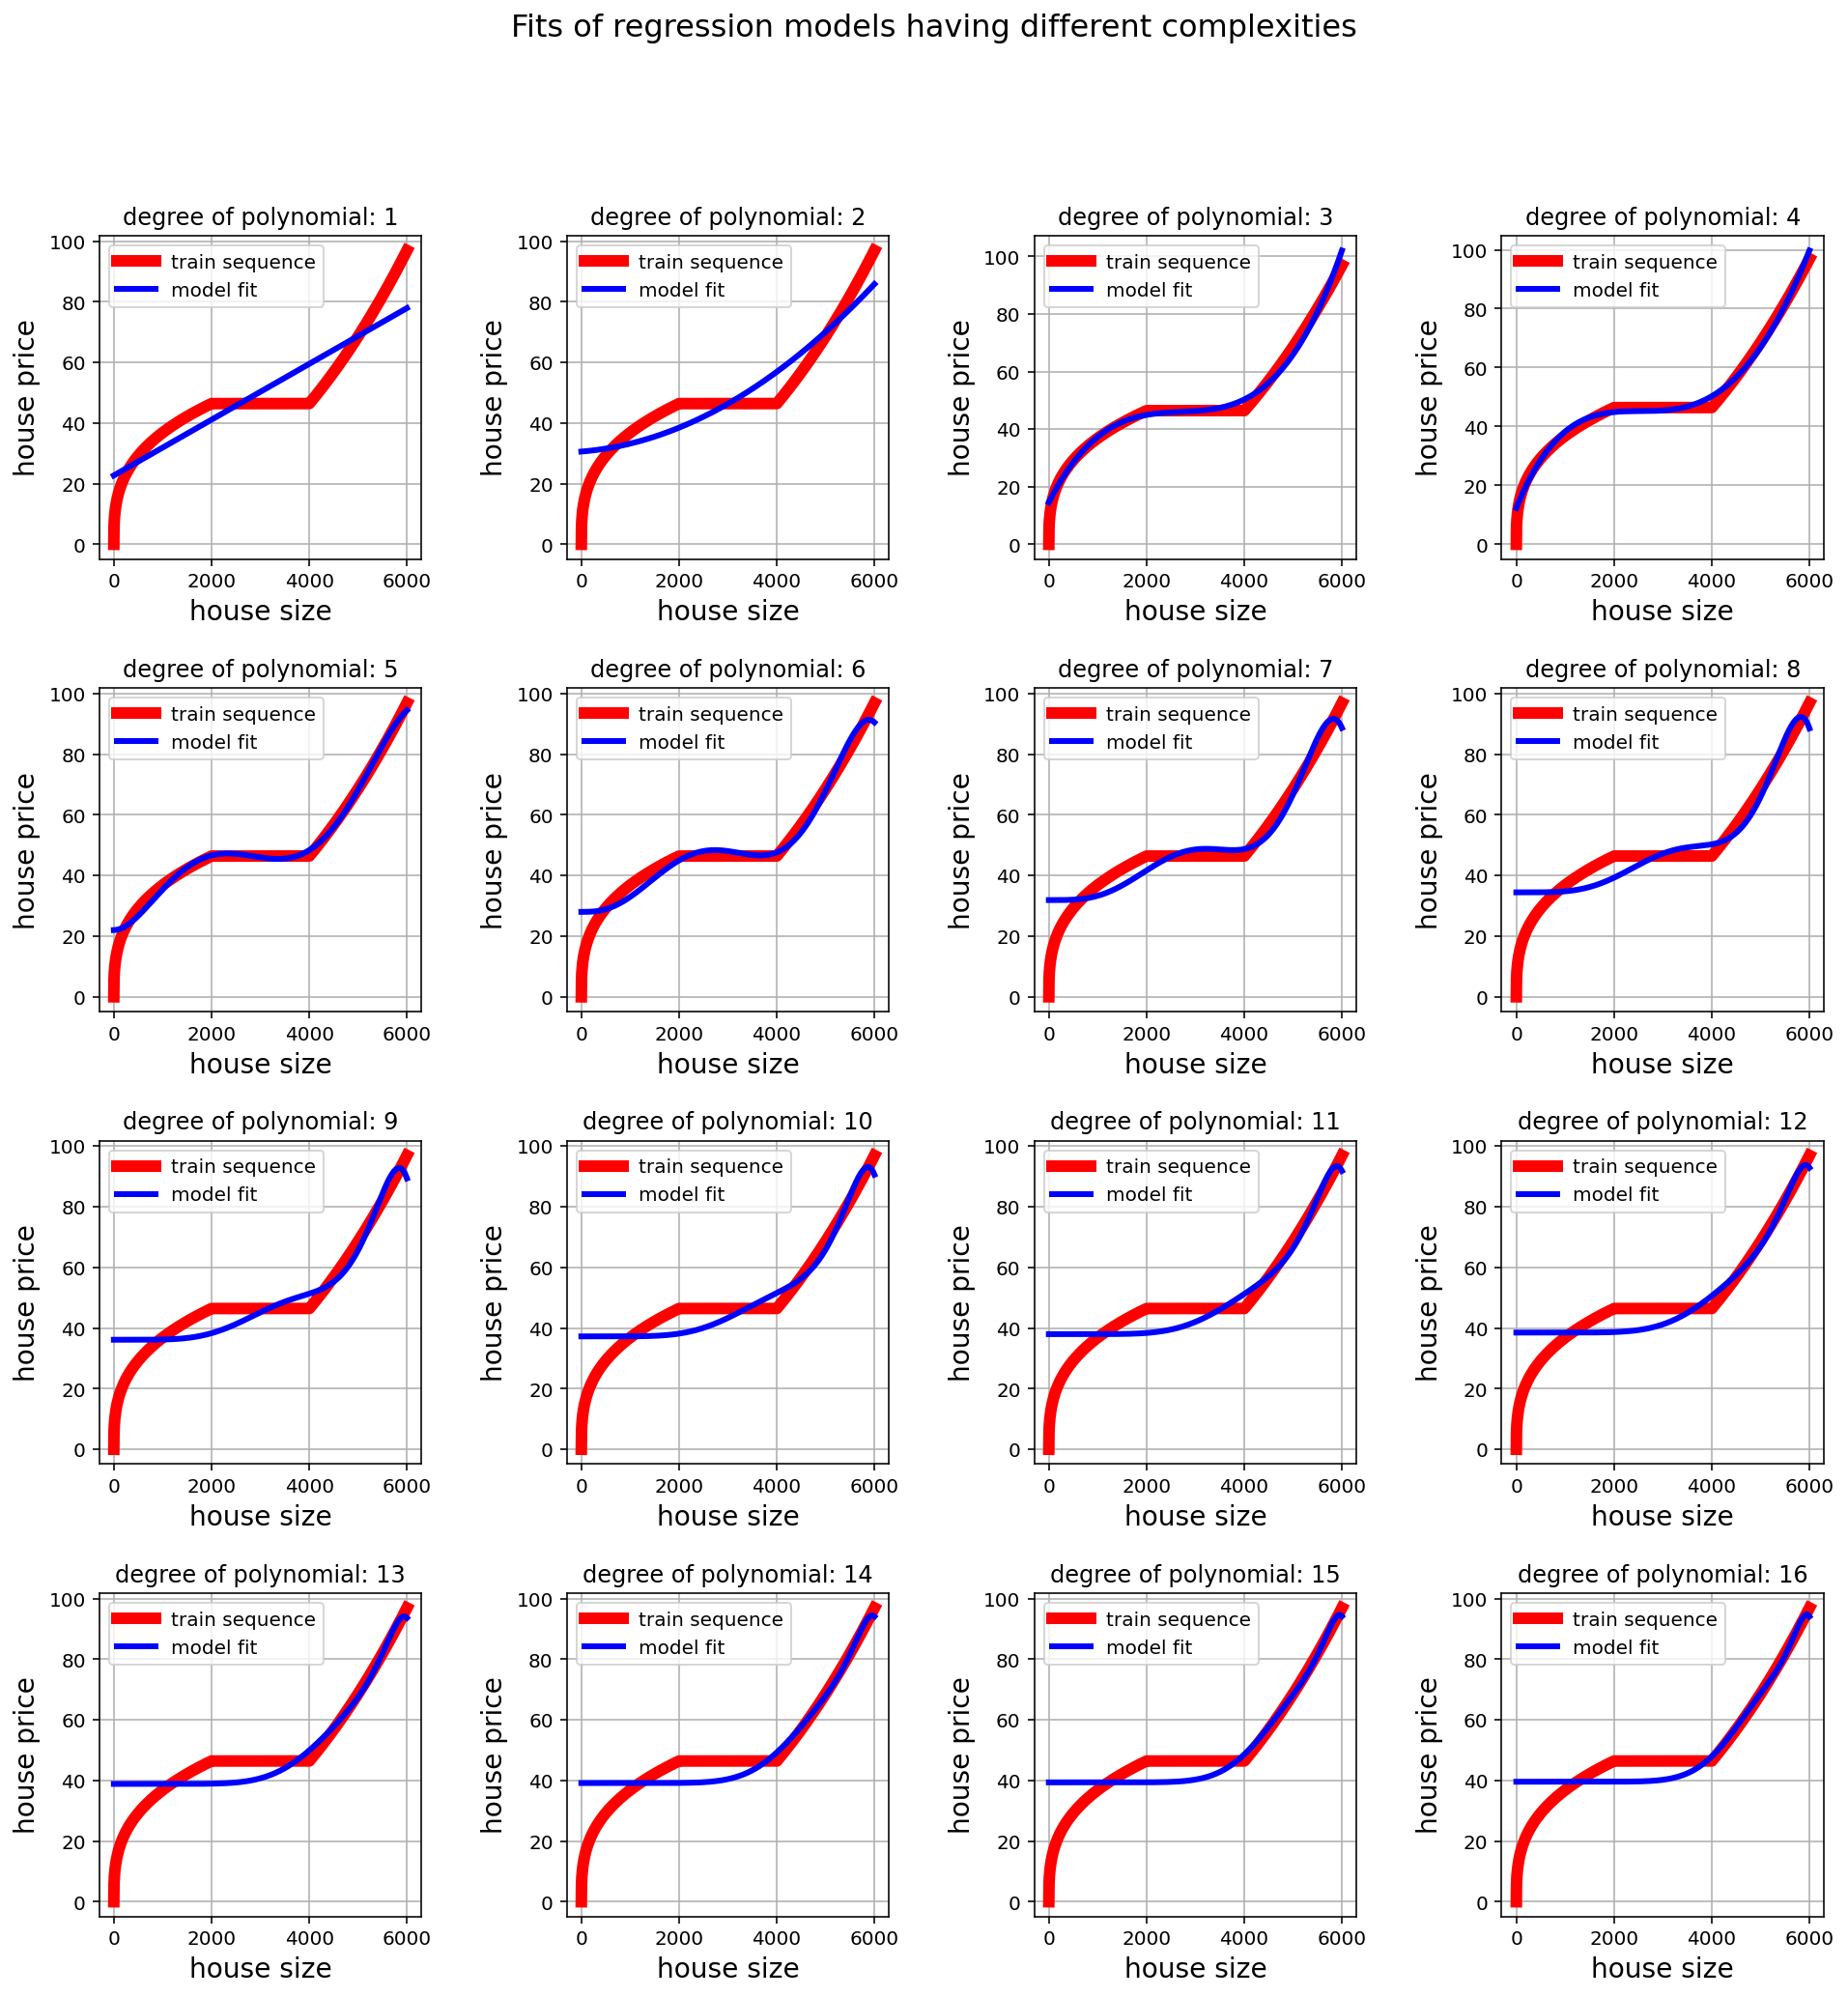

In [10]:
# configure the matplotlib figure size
matplotlib.rcParams['figure.figsize'] = (16.0, 16.0)
# create train and test sets
train_data, test_data = train_test_split(data, test_size=0.1, random_state =0)
# list of degrees of model complexity
degrees = np.linspace(1,16,num =16,dtype=int)
# create a linear regression model without parenthesis, 
# so that its parameters can be controlled after function invocation 
model = LinearRegression
# create the plots of model fits and collect the r squared score of models having different complexities
r2_scores = polynomial_regression_plot(degrees, model, train_data,test_data, "house_size", "house_price", [4,4])

**Print the r-squared scores of the regression models having different complexities**

In [11]:
results = pd.DataFrame({"Degree": degrees, "R2 score": r2_scores})
print(results.to_string(index=False))

 Degree  R2 score
      1  0.820107
      2  0.868780
      3  0.990835
      4  0.993348
      5  0.988704
      6  0.965109
      7  0.934532
      8  0.909294
      9  0.891739
     10  0.880307
     11  0.872993
     12  0.868188
     13  0.864811
     14  0.862215
     15  0.860033
     16  0.858052


## 3. Visualize the fit of a KNN model (k=5)

**Extract feature matrix and output vector of train and test set**

In [12]:
(X_train, y_train) = get_xy_data(train_data,["house_size"], "house_price")
(X_test, y_test) = get_xy_data(test_data,["house_size"], "house_price")

**Create and fit the KNN regressor model**

In [13]:
model = knn_regressor(k = 5)
model.fit(X_train, y_train)

**Plot of the KNN model fit**

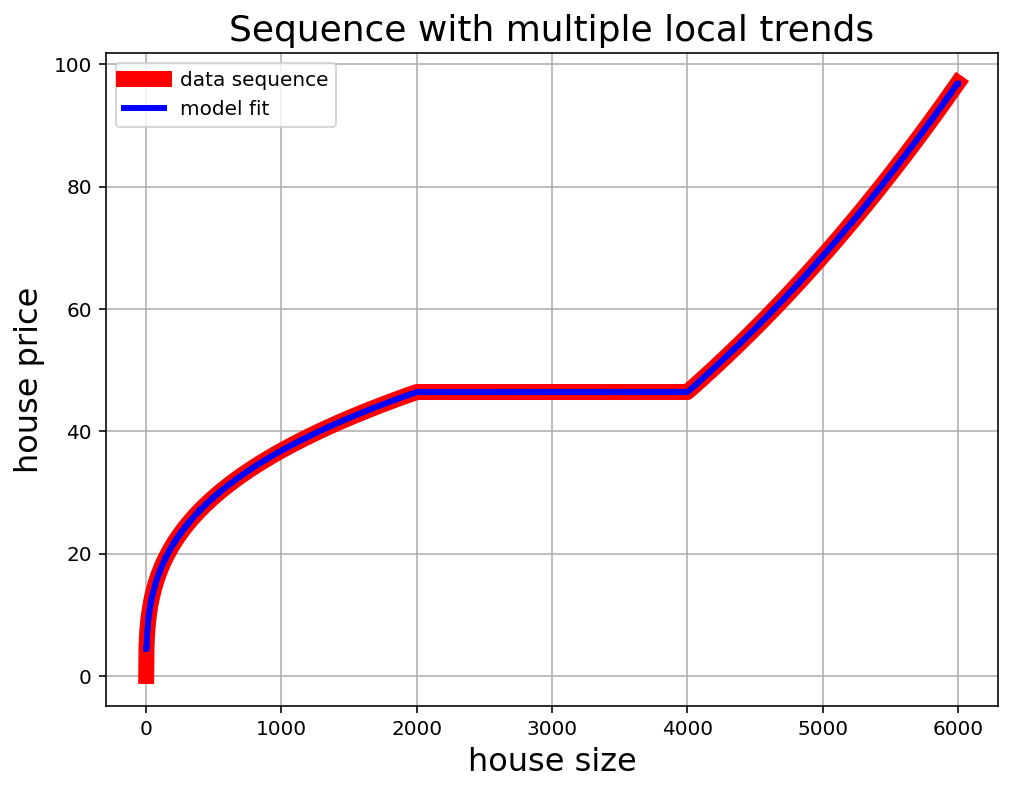

In [14]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
plt.plot(data.house_size,data.house_price,'-',color = 'r',linewidth = 8, label = "data sequence")
plt.plot(data.house_size,model.predict(data.house_size), '-', color = "b",linewidth = 3, label = "model fit")
plt.title("Sequence with multiple local trends", fontsize = 18)
plt.xlabel("house size", fontsize = 16)
plt.ylabel("house price", fontsize = 16)
plt.legend()
plt.grid()
plt.show()

**Print the r-squared score of the knn model**

In [15]:
print("R-squared score of KNN model", r2_score(y_test, model.predict(X_test)))

R-squared score of KNN model 0.999994920917574
